In [1]:
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
from skimage import color
from skimage import io
import pandas as pd
from PIL import Image
import collections


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
def to_index(name):
    return int(name[:6])

In [4]:
def to_name(index):
    name = ''
    for i in range(6 - len(str(index))):
        name += '0'
    name = name + str(index) + '.jpg'
    return name

In [5]:
def load_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((128,128), Image.ANTIALIAS)
            temp = rgb2gray(np.array(new_img))
            images[to_index(filename)] = temp   
    return images, sizes

In [6]:
def load_rgb_images_from_folder(folder):
    images = {}
    sizes = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None: 
            sizes[to_index(filename)] = img.size  
            new_img = img.resize((64,64), Image.ANTIALIAS)
            images[to_index(filename)] = new_img   
    return images, sizes

In [7]:
def change_bbox(name, old_w, old_h, df):
    df.at[to_index(name)-1, 'x_1'] *= (64/old_w)
    df.at[to_index(name)-1, 'y_1'] *= (64/old_h)
    df.at[to_index(name)-1, 'width'] *= (64/old_w)
    df.at[to_index(name)-1, 'height'] *= (64/old_h)

In [8]:
folder_name = 'Data/Part 1/Part 1'
train_imgs1, old_sizes1= load_rgb_images_from_folder(folder_name)

In [9]:
folder_name = 'Data/Part 2/Part 2'
train_imgs2, old_sizes2= load_rgb_images_from_folder(folder_name)

In [16]:
train_imgs = { **train_imgs1, **train_imgs2}

In [18]:
old_sizes = { **old_sizes1, **old_sizes2}

In [43]:
del train_imgs1
del old_sizes1
del train_imgs2
del old_sizes2

In [19]:
od = collections.OrderedDict(sorted(train_imgs.items())) #ordered dict

In [45]:
del train_imgs

In [20]:
df = pd.read_csv('Data/list_bbox_celeba.csv')

In [21]:
for i in od.keys():
    img_number = i
    change_bbox(to_name(img_number), old_sizes[img_number][0], old_sizes[img_number][1], df)

In [38]:
tst = []
for i in range(1,20000):
    tst.append(np.array(od[i]))

In [43]:
X_train = np.array(tst[:19000])
X_val = np.array(tst[19000:19500])
X_test = np.array(tst[19500:])
Y_train = np.array(df.drop(columns=['image_id'],axis = 1)[:19000])
Y_val = np.array(df.drop(columns=['image_id'],axis = 1)[19000:19500])
Y_test = np.array(df.drop(columns=['image_id'],axis = 1)[19500:])

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
model = keras.Sequential()
model.add(keras.Input(shape=(64, 64, 3)))
model.add(layers.Conv2D(64, kernel_size=(9, 9), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.PReLU())
model.add(layers.Dense(4))

model.summary()
model.compile('adadelta', loss='mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        15616     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        16448     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)       

In [46]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=1, batch_size=64)

Epoch 1/10
297/297 [==============================] - 406s 1s/step - loss: 250.3421 - val_loss: 168.5134
Epoch 2/10
297/297 [==============================] - 406s 1s/step - loss: 96.8801 - val_loss: 84.3764
Epoch 3/10
297/297 [==============================] - 408s 1s/step - loss: 72.8760 - val_loss: 68.2232
Epoch 4/10
297/297 [==============================] - 409s 1s/step - loss: 60.9136 - val_loss: 60.4362
Epoch 5/10
297/297 [==============================] - 409s 1s/step - loss: 54.8217 - val_loss: 56.1573
Epoch 6/10
297/297 [==============================] - 407s 1s/step - loss: 51.1491 - val_loss: 53.0706
Epoch 7/10
297/297 [==============================] - 408s 1s/step - loss: 48.5840 - val_loss: 51.4550
Epoch 8/10
297/297 [==============================] - 408s 1s/step - loss: 46.5658 - val_loss: 49.3861
Epoch 9/10
297/297 [==============================] - 409s 1s/step - loss: 44.8890 - val_loss: 48.0946
Epoch 10/10
297/297 [==============================] - 409s 1s/step - l

In [27]:
y_pred = model.predict(X_test)

In [28]:
def custom_loss(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return tf.summary.scalar('name', 1, step=None, description=None)

    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return tf.summary.scalar('name', 1 - I / U, step=None, description=None)


In [29]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [30]:
def calc_accuracy(y_pred, y_test):
    tmp = []
    for i in range(len(y_pred)):
        tmp.append(IOU(y_pred[i], y_test[i]))
    
    return np.average(tmp)
    

In [31]:
calc_accuracy(y_pred, Y_test)

0.49891020650880274

In [32]:
y_pred[1]

array([15.562164, 10.647701, 35.259544, 41.902267], dtype=float32)

In [33]:
Y_test[1]

array([ 6,  5, 52, 51])

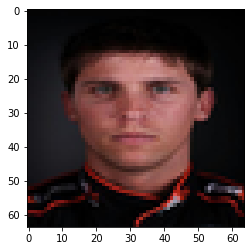

In [34]:
plt.imshow(X_test[1])

In [35]:
def draw_bbox(img, bbox):

    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

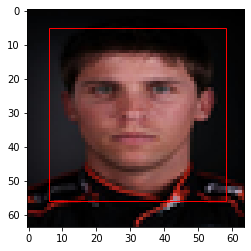

In [36]:
draw_bbox(X_test[1],Y_test[1])


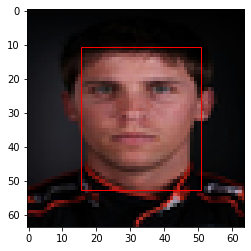

In [37]:
draw_bbox(X_test[1],y_pred[1])

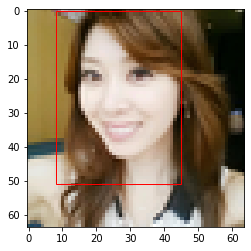

In [87]:
draw_bbox(X_test[2],Y_test[2])

In [88]:
IOU(Y_test[1], y_pred[1])

0.5966410961877744

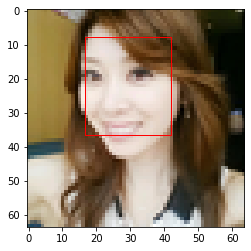

In [89]:
draw_bbox(X_test[2],y_pred[2])

In [60]:
draw_bbox(X_test[499],y_pred[499])

IndexError: index 499 is out of bounds for axis 0 with size 499

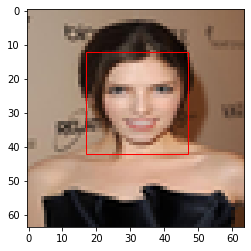

In [90]:
draw_bbox(X_test[16],Y_test[16])

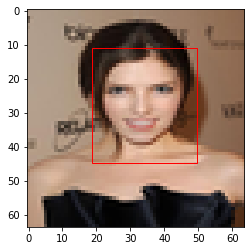

In [91]:
draw_bbox(X_test[16], y_pred[16])

In [92]:
for i in range(2,50):
    print(IOU(Y_test[i], y_pred[i]))

0.39253033862801706
0.20765237804797748
0.30582959199074433
0.5239771060952118
0.6816547339841925
0.6838105604439894
0.2526546902126736
0.4429434085471979
0.3835976128421988
0.6598015050889687
0.16904044813969524
0.23060171902208712
0.7922880718166743
0.11836453783232968
0.7695592546849382
0.5743599214542698
0.6606794088842981
0.6444889326423758
0.5538940594775826
0.693693034121703
0.6519588602860068
0.630637803255676
0.7232016560042708
0.3934541572714426
0.2129220332128747
0.5546158533567307
0.565589959620585
0.6862821678993954
0.23119117592011987
0.0
0.4550606152528611
0.624312323823913
0.49840871766240685
0.18913257032476363
0.5953932441683867
0.12081448576372313
0.4877023418974077
0.1712388142602379
0.6542145322039904
0.5830497645654187
0.19182132061897902
0.23015375052728407
0.3899843660154249
0.38952186516514875
0.5278537812885674
0.31562494399758145
0.23903338283651465
0.4630456532353412
